In [1]:
import warnings
warnings.filterwarnings("ignore")

In this Notebook we will walk through what the K-Nearest Neighbors algorithm is, and how to implement it with RAPIDS cuML for both classification and regression.

# K-Nearest Neighbors with cuML
K-Nearest Neighbors (KNN) is a simple way to determine the value of something by asking what the values of the K nearest things to it are.

So if K=3, what are the 3 nearest things?

![KNN classification, K=3](https://cdn-images-1.medium.com/max/800/0*49s1xDlDKDsn55xa.gif)

## Implementing KNN with cuML
We'll first walk through KNN for classification (`KNeighborsClassifier`), then run through KNN for regression (`KNeighborsRegressor`).

### Step 1: Start with a Dataset with Known Target Values

In our case, we have 3 species of Iris flower (Iris setosa, Iris virginica and Iris versicolor) from Fischer's Iris dataset.

In [2]:
import cudf

df = cudf.read_csv('https://github.com/gumdropsteve/datasets/raw/master/iris.csv')

In [3]:
df.species.unique()

0        setosa
1    versicolor
2     virginica
Name: species, dtype: object

50 instances (flowers) of each species were recorded, making 150 total records (rows).

![iris species](https://cdn-images-1.medium.com/max/800/0*XWbAz8JSpDxsnc8d)

4 features - the length and width of the sepals and petals -  were measured in centimeters from each flower.

In [4]:
df

,sepal_length,sepal_width,petal_length,petal_width,species,target
0,5.1,3.5,1.4,0.2,setosa,0
1,4.9,3.0,1.4,0.2,setosa,0
2,4.7,3.2,1.3,0.2,setosa,0
3,4.6,3.1,1.5,0.2,setosa,0
4,5.0,3.6,1.4,0.2,setosa,0
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica,2
146,6.3,2.5,5.0,1.9,virginica,2
147,6.5,3.0,5.2,2.0,virginica,2
148,6.2,3.4,5.4,2.3,virginica,2


Using these 4 features, Fisher developed a linear discriminant model to distinguish the species from each other.

#### Data Prep
IRL, you may often need to identify clusters in your dataset (our data has already been clustered because we know the species of each recorded flower). This can be done a number of ways including PCA and K-Means clustering.

Before we visualize the species clusters, however, we should use cuML's `train_test_split()` function to break the dataset into training and testing subsets. This will allow us to judge performance with real data the model has never seen.

In [5]:
from cuml.preprocessing.model_selection import train_test_split

df = df.drop('species')

X_train, X_test, y_train, y_test = train_test_split(df, 'target', train_size=0.8)

Now, by converting the X_train cudf.DataFrame `.to_pandas()`, we can easily visualize species clusters through Matplotlib.

In this `.plot()` the red dots are virginica instances, the purple dots are setosa, and those in between are versicolor. Setting `c=y_train.to_array()` gives the `cmap` context to differentiate between species.

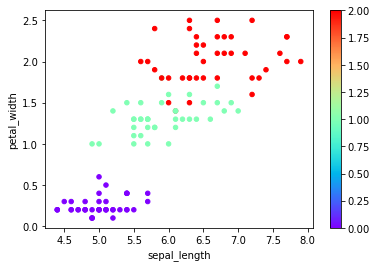

In [6]:
X_train.to_pandas().plot(kind='scatter', 
                         x='sepal_length', 
                         y='petal_width',
                         c=y_train.to_array(), cmap=('rainbow'), sharex=False)

#### **KNN for Classification**
K-Nearest Neighbors Classifier is an instance-based learning technique, that keeps training samples around for prediction, rather than trying to learn a generalizable set of model parameters.

In [7]:
from cuml.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)

Understanding the data, we can create and `.fit()` ("train") cuML's KNeighborsClassifier model with `X_train` and `y_train`.

In [8]:
knn.fit(X_train, y_train)

KNeighborsClassifier(weights='uniform')

### Step 2: Add New Data with Unknown Target Values
It's time to add in our testing data. Let's scatter the `X_test` flowers in black on top  of the rainbow plot to better understand where they're coming from.

In [9]:
from matplotlib import pyplot as plt

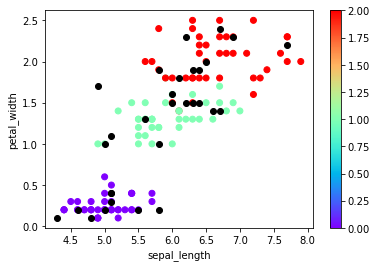

In [10]:
plt.xlabel('sepal_length'), plt.ylabel('petal_width')

# scatter training dataset (rainbow) + colorbar
plt.scatter(x=X_train['sepal_length'].to_pandas(), y=X_train['petal_width'].to_pandas(),
            c=y_train.to_pandas(), cmap='rainbow')
plt.colorbar()

# scatter testing dataset (black)
plt.scatter(x=X_test['sepal_length'].to_pandas(), y=X_test['petal_width'].to_pandas(),
            color='k')

While it's pretty easy to guess which test flowers are setosa, it's not so obvious for the virginica or the versicolor.

### Step 3: Classify the New Data
We can classify these new `X_test` flowers by looking at the species of the nearest recorded flowers from `X_train`.

In [11]:
results = knn.predict(X_test)

results.tail()

25    0
26    1
27    2
28    1
29    1
dtype: int32

#### Classifier Results
Making a `.copy()` of the `X_test` DataFrame, we can add `actual` and `predicted` columns from `y_test` and `results` values (respectively).

This results DataFrame (`df`) will help us examine performance.

In [12]:
df = X_test.copy()

df['actual'] = y_test.values
df['predicted'] = results.values

df.tail()

,sepal_length,sepal_width,petal_length,petal_width,actual,predicted
145,5.1,3.7,1.5,0.4,0,0
146,5.0,2.3,3.3,1.0,1,1
147,6.3,2.5,4.9,1.5,1,2
148,6.2,2.2,4.5,1.5,1,1
149,5.6,3.0,4.1,1.3,1,1


How many instances did we `.predict()` correctly?

In [13]:
n_correct = len(df.loc[df['actual']==df['predicted']])
n_possible = len(df)

print(f'{n_correct} / {n_possible} correct\n{str(n_correct / n_possible * 100)[:5]}% accuracy')

28 / 30 correct
93.33% accuracy


Visualize by adding the correctly predicted species to the rainbow map alongside `X_train` and the incorrectly predicted flowers in black.

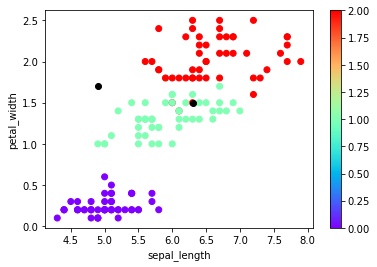

In [14]:
df_correct = df.loc[df['actual'] == df['predicted']]
df_incorrect = df.loc[df['actual'] != df['predicted']]

plt.xlabel('sepal_length'), plt.ylabel('petal_width')

# plot training instances (rainbow) + colorbar
plt.scatter(x=X_train['sepal_length'].to_pandas(), y=X_train['petal_width'].to_pandas(),
            c=y_train.to_pandas(), cmap='rainbow')
plt.colorbar()

# plot correctly predicted instances (rainbow)
plt.scatter(x=df_correct['sepal_length'].to_pandas(), y=df_correct['petal_width'].to_pandas(),
            c=df_correct['actual'].to_pandas(), cmap='rainbow')

# plot incorrectly predicted instances (black) (except: means 1 or less incorrect)
try:
    plt.scatter(x=df_incorrect['sepal_length'].to_pandas(), y=df_incorrect['petal_width'].to_pandas(), color='k')
except:
    plt.scatter(x=df_incorrect['sepal_length'], y=df_incorrect['petal_width'], color='k')

And let's see those rows.

In [15]:
df_incorrect

,sepal_length,sepal_width,petal_length,petal_width,actual,predicted
120,4.9,2.5,4.5,1.7,2,1
147,6.3,2.5,4.9,1.5,1,2


#### **KNN for Regression**
K-Nearest Neighbors Regressor is an instance-based learning technique that keeps training samples around for prediction, rather than trying to learn a generalizable set of model parameters. The K-Nearest Neighbors Regressor will compute the average of the labels for the k closest neighbors and use it as the label.

Creating the model, fitting it with data, and making predictions is done the same here for regression as it just was for classification.

In [16]:
from cuml.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=3)

In [17]:
knn.fit(X_train, y_train)

KNeighborsRegressor(weights='uniform')

In [18]:
results = knn.predict(X_test)

results.tail()

25    0.000000
26    1.000000
27    1.666667
28    1.333333
29    1.000000
dtype: float32

Because of the nature of regression, results are returned as floating point values. Notice some predictions might have neighbors of different species, leading the `KNeighborsRegressor` to predict values like 1.666667.

#### Regressor Results
Let's add back the actual (`y_test`) values along with the predicted (`results`) to a `.copy()` of the `X_test` DataFrame and show the last 5 rows.

In [19]:
df = X_test.copy()

df['actual'] = y_test.values
df['predicted'] = results.values

df.tail()

,sepal_length,sepal_width,petal_length,petal_width,actual,predicted
145,5.1,3.7,1.5,0.4,0,0.000000
146,5.0,2.3,3.3,1.0,1,1.000000
147,6.3,2.5,4.9,1.5,1,1.666667
148,6.2,2.2,4.5,1.5,1,1.333333
149,5.6,3.0,4.1,1.3,1,1.000000


How many instances did we `.predict()` correctly?

In [20]:
n_correct = len(df.loc[df['actual']==df['predicted']])
n_possible = len(df)

print(f'{n_correct} / {n_possible} correct\n{str(n_correct / n_possible * 100)[:5]}% accuracy')

26 / 30 correct
86.66% accuracy


Visualize by adding the correctly predicted species to the rainbow map alongside `X_train` and the incorrectly predicted flowers in black.

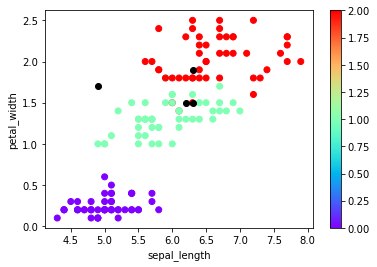

In [21]:
df_correct = df.loc[df['actual'] == df['predicted']]
df_incorrect = df.loc[df['actual'] != df['predicted']]

plt.xlabel('sepal_length'), plt.ylabel('petal_width')

# plot training instances (rainbow) + colorbar
plt.scatter(x=X_train['sepal_length'].to_pandas(), y=X_train['petal_width'].to_pandas(),
            c=y_train.to_pandas(), cmap='rainbow')
plt.colorbar()

# plot correctly predicted instances (rainbow)
plt.scatter(x=df_correct['sepal_length'].to_pandas(), y=df_correct['petal_width'].to_pandas(),
            c=df_correct['actual'].to_pandas(), cmap='rainbow')

# plot incorrectly predicted instances (black) (except: means 1 or less incorrect)
try:
    plt.scatter(x=df_incorrect['sepal_length'].to_pandas(), y=df_incorrect['petal_width'].to_pandas(), color='k')
except:
    plt.scatter(x=df_incorrect['sepal_length'], y=df_incorrect['petal_width'], color='k')

In [22]:
df_incorrect

,sepal_length,sepal_width,petal_length,petal_width,actual,predicted
120,4.9,2.5,4.5,1.7,2,1.000000
130,6.3,2.5,5.0,1.9,2,1.666667
147,6.3,2.5,4.9,1.5,1,1.666667
148,6.2,2.2,4.5,1.5,1,1.333333


## Nearest Neighbors
Before we wrap up K-Nearest Neighbors, we should get familiar with the Nearest Neighbors algorithm, which enables the query of the K-Nearest Neighbors from a set of input samples. cuML uses [Faiss](https://github.com/facebookresearch/faiss) to run the Nearest Neighbors query.

In [23]:
from cuml.neighbors import NearestNeighbors

nn = NearestNeighbors(n_neighbors=3)

Let's `.fit()` the `NearestNeighbors` model with our `X_train` data. Note the model is being fed all 4 measurements from each flower, but it is not being told which species any of those flowers belong to.

In [24]:
nn.fit(X_train)

NearestNeighbors(n_neighbors=3, verbose=2, handle=<cuml.common.handle.Handle object at 0x7fada5460af0>, algorithm='brute', metric='euclidean', output_type='cudf')

We can now call `.kneighbors()` to query for the k nearest neighbors of column vectors in `df`. The method returns a tuple with 2 cudf.DataFrames holding the *distances* and *indices* of the k-nearest neighbors for each column vector in X.

Let's query for the 3 nearest neighbors of the first 5 points in our testing set (`X_test[:5]`).

In [25]:
distances, indices = nn.kneighbors(X_test[:5])

How far away are the 3 nearest points?

In [26]:
distances

,0,1,2
0,0.734853,0.761576,0.793724
1,0.412318,0.818525,0.860240
2,0.244948,0.316225,0.346403
3,0.244944,0.264575,0.316225
4,0.099992,0.141423,0.173202


At what indices (of `X_train`) can those points be found?

In [27]:
indices

,0,1,2
0,85,28,119
1,92,81,29
2,84,88,24
3,44,71,54
4,42,45,2


Let's use the first row of `indices` to classify the 0th flower in `X_test`.

species    | target
---        | ---
setosa     | 0
versicolor | 1
virginica  | 2

This cell prints the neighbor's position of closeness, index of the neighbor and that neighbor's `target` (Iris species).

In [28]:
n = 0
votes = []

for i in indices.loc[0]:
    print(f'neighbor: {n}\nindex: {i}\nvote: {y_train.iloc[i]}\n')
    n += 1
    votes.append(y_train.iloc[i])
    
print(f'***\nClassification: {max(set(votes), key=votes.count)}')

neighbor: 0
index: 85
vote: 1

neighbor: 1
index: 28
vote: 1

neighbor: 2
index: 119
vote: 1

***
Classification: 1


# Continued Learning 
Here are some resources to help fill in any gaps and provide a more complete picture.

#### **StatQuest: K-nearest neighbors, Clearly Explained**
- Watch on YouTube: [youtu.be/HVXime0nQeI](https://youtu.be/HVXime0nQeI)
- Channel: StatQuest with Josh Starmer ([Subscribe](https://www.youtube.com/channel/UCtYLUTtgS3k1Fg4y5tAhLbw?sub_confirmation=1))

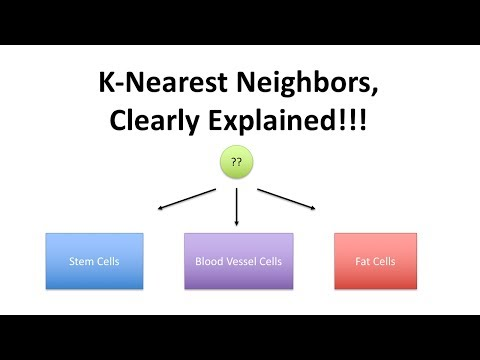

In [29]:
from IPython.display import YouTubeVideo
YouTubeVideo('HVXime0nQeI', width=(1280*0.69), height=(720*0.69))

#### **_k_-nearest neighbors algorithm**
Wikipedia: [https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm)

#### **Nearest Neighbour Algorithm - Part 1**
- Watch on YouTube: [youtu.be/JH2IUFmP8JI](https://youtu.be/JH2IUFmP8JI)
- Channel:  Darren Barton ([Subscribe](https://www.youtube.com/user/bartondeb1?sub_confirmation=1))

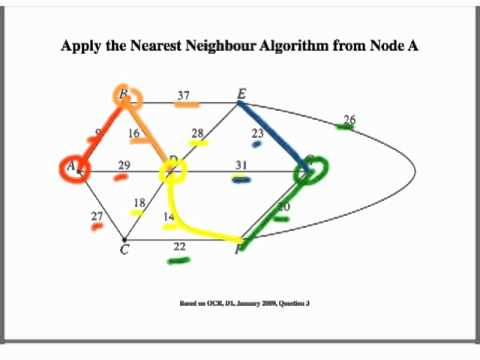

In [30]:
from IPython.display import YouTubeVideo
YouTubeVideo('JH2IUFmP8JI', width=720, height=480)

#### **Nearest neighbour algorithm**
Wikipedia: [https://en.wikipedia.org/wiki/Nearest_neighbour_algorithm](https://en.wikipedia.org/wiki/Nearest_neighbour_algorithm) 